**Introduction to Autoencoders:**<br>
Autoencoders are a type of artificial neural network used for unsupervised learning, dimensionality reduction, and feature learning. They belong to the broader family of neural networks and are particularly popular in the field of deep learning. Autoencoders are designed to encode input data into a compact representation and then reconstruct the input data from this representation. The primary goal is to learn a useful and efficient representation of the input data.<br>

Here's a breakdown of the key components and concepts associated with autoencoders:<br>

**Encoder**: The encoder is the first half of the autoencoder. It takes the input data and transforms it into a reduced-dimensional representation. This process involves compressing the input information into a concise set of features.<br>

**Decoder**: The decoder is the second half of the autoencoder. It takes the reduced-dimensional representation created by the encoder and reconstructs the input data as closely as possible. The aim is to generate an output that is a meaningful reconstruction of the original input.

Here, we are gonna build autoencoder model using convolutional ,pooling and transpose convloutional layers and apply it on cifar-10 dataset and training the model to get minimum reconstruction loss.



Firstly, we have to load the data.<br>
Pytorch has already cifar-10 dataset so, we dont have to download it explicilty.


1.   Now we have to get the data from torchvision.datasets with applied transforms(i.e ToTensor())
2.Then we have to load the data into batches, training data in batches takes computation cost.   




In [ ]:
import torch

In [ ]:
device ="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
from torchvision import datasets
from torchvision import transforms

transform = transforms.Compose(
        [transforms.ToTensor(), ])
train_data = datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_data, batch_size=16,
                                              shuffle=True, num_workers=2)
test_data = datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform)
testloader = torch.utils.data.DataLoader(test_data, batch_size=16,
                                             shuffle=False, num_workers=0)

100%|██████████| 170498071/170498071 [00:01<00:00, 101597228.21it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(test_data)

10000

Lets display some images, from the loaded data.<br>
visualization helps us to understand the data and we know on what we are doing our training rather just thinking them as bunch of numbers.
Here im using matplotlib.pyplot , matplotlib is popular python library to visualize data.

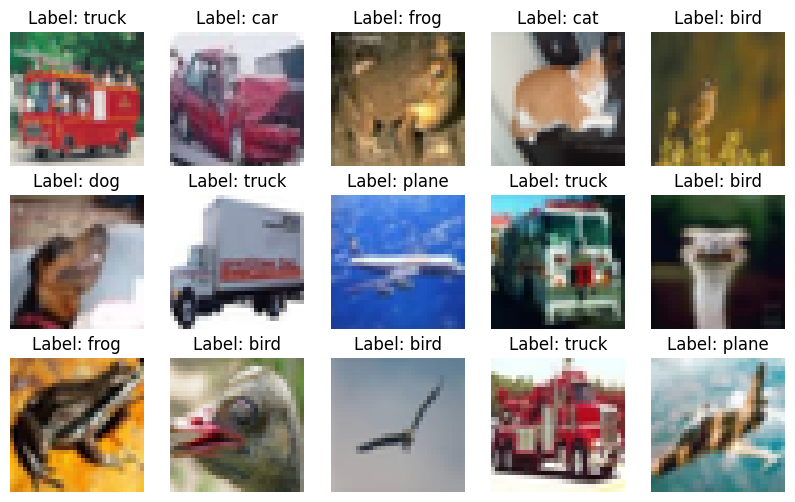

In [ ]:
import matplotlib.pyplot as plt
import random
import numpy as np

random.seed(56)
num_cols=5
num_rows=3
Labels = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6))
for i in range(num_cols*num_rows):
  img,label=train_data[random.randint(0,50000)]
  row = i // num_cols
  col = i % num_cols
  axes[row, col].imshow(np.transpose(img, (1, 2, 0)))
  axes[row, col].set_title(f"Label: {Labels[label]}")
  axes[row, col].axis('off')


Now coming model Architecture:<br>
We will define our model in two parts, encoder and decoder. As defined before from encoding part we get set Reduced dimensional features from that we have to decode the image.<br>
To do this we have defined encoder architecture using some convlutional layers and pooling layers(i.e max pooling).<br><br>
First we have reduced the spatial dimensions to point then after in decoder part, we have done symmentrical upsmapling to get the initial spatial dimensions at the end of the model.<br><br>
In encoder we have reduced (32\*32\*3)->(8\*8\*128)<br>
And in decoder we have increased (8\*8\*128)->(32\*32\*3)



In [ ]:
import torch.nn as nn

class autoEncoders(nn.Module):
  def __init__(self):
    super(autoEncoders, self).__init__()
    self.encoder = nn.Sequential(
        nn.Conv2d(3,32,kernel_size=3,stride=1,padding=1),#(32*32*3)->(32*32*32)
        nn.ReLU(),
        nn.Conv2d(32,64,kernel_size=3,stride=1,padding=1),
        nn.MaxPool2d(2,2),#(32*32*64)->(16*16*64)
        nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),#(16*16*128)->(8*8*128)
        )
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(128, 128, kernel_size=4, stride=2, padding=1, output_padding=0),  # (8*8*128) -> (16*16*128)
        nn.ReLU(),
        nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),  # (16*16*128) -> (16*16*64)
        nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1, output_padding=0),  # (16*16*64) -> (32*32*64)
        nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),  # (32*32*64) -> (32*32*32)
        nn.ReLU(),
        nn.Conv2d(32, 3, kernel_size=3, stride=1, padding=1),  # (32*32*32) -> (32*32*3)
        nn.Sigmoid()
        )

  def forward(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return encoded, decoded


In [ ]:
model =autoEncoders().to(device)
model

autoEncoders(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU()
    (6): Conv2d(32, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): Sigmoid()
  )
)

After defining model structure, now we have to train the model.<br>
for that we have first declare loss function and optimiszer. They are many loss functions and optimizers. MSE(mean squared error) and BCE(binary cross entropy loss) are more suitable for autoencoder models. and we are Adam optimiser which very effective in these type of models.
<br><br>
During training we have to update kernerls inorder to minimise reconstruction loss. Reconstruction loss is loss between output image provided by model and input image.

In [ ]:
loss_func = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
from torch.autograd import Variable
def get_torch_vars(x):
  if torch.cuda.is_available():
        x = x.cuda()
  return Variable(x)

model.train()
for epoch in range(20):
  running_loss = []
  for i, (inputs, _) in enumerate(trainloader, 0):
    inputs = get_torch_vars(inputs)
    encoded, outputs = model(inputs)
    loss = loss_func(outputs, inputs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss.append(loss.data)
    if i % 2000 == 1999:
      print('[%d, %5d] loss: %.9f' %(epoch + 1, i + 1,sum(running_loss)/len(running_loss)))

[1,  2000] loss: 0.558659077
[2,  2000] loss: 0.550150514
[3,  2000] loss: 0.549239159
[4,  2000] loss: 0.549301982
[5,  2000] loss: 0.548763454
[6,  2000] loss: 0.548888564
[7,  2000] loss: 0.548934102
[8,  2000] loss: 0.547930062
[9,  2000] loss: 0.548026502
[10,  2000] loss: 0.547998309
[11,  2000] loss: 0.548311055
[12,  2000] loss: 0.548541009
[13,  2000] loss: 0.548216939
[14,  2000] loss: 0.547846019
[15,  2000] loss: 0.547646642
[16,  2000] loss: 0.547618508
[17,  2000] loss: 0.547948956
[18,  2000] loss: 0.547992945
[19,  2000] loss: 0.547868669
[20,  2000] loss: 0.547584772


Now test the model on test data and note the loss.

In [ ]:
model.eval()
test_loss=[]
for i,(inputs,label) in enumerate(testloader,0):
  inputs = get_torch_vars(inputs)
  encoded,test_outputs = model(inputs)
  loss = loss_func(test_outputs, inputs)
  test_loss.append(loss.data)
print('loss: %.5f' %(sum(test_loss)/len(test_loss)))

loss: 0.54856


We got the loss similar to training. Hence, training doesnt leads to over fitting.

Lets, plot some of the test images and images which are resulted with trained parameters

test images before passing them into model


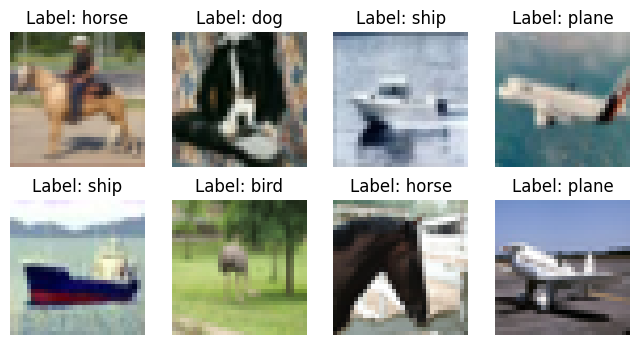

In [ ]:
num_cols=4
num_rows=2
print("test images before passing them into model")
fig, axes = plt.subplots(num_rows, num_cols, figsize=(8, 4))
for i in range(num_rows*num_cols):
  row = i // num_cols
  col = i % num_cols
  axes[row,col].imshow(inputs[i].cpu().detach().numpy().transpose(1, 2, 0))
  axes[row,col].set_title(f"Label: {Labels[label[i]]}")
  axes[row,col].axis('off')


test images plotted with trained parameters


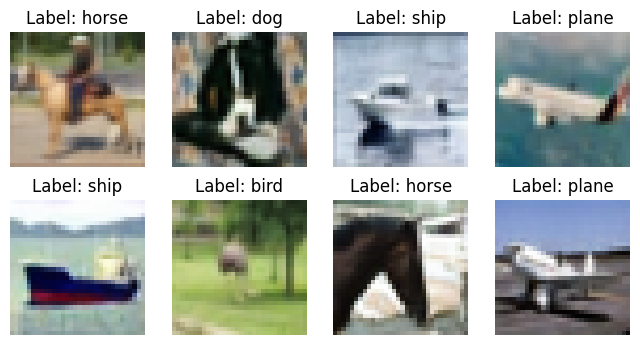

In [ ]:
print("test images plotted with trained parameters")
test_fig, test_axes = plt.subplots(num_rows, num_cols, figsize=(8, 4))
for i in range(num_rows*num_cols):
  row = i // num_cols
  col = i % num_cols
  test_axes[row,col].imshow(test_outputs[i].cpu().detach().numpy().transpose(1, 2, 0))
  test_axes[row,col].set_title(f"Label: {Labels[label[i]]}")
  test_axes[row,col].axis('off')


**Applications of Auto Encoders:**<br>
Autoencoders find diverse applications across various domains due to their ability to learn efficient data representations. Some notable applications include:


1.  **Data Compression**:
Autoencoders are used for compressing data into a compact representation while retaining essential features. This is particularly valuable in scenarios where storage or bandwidth is limited, such as image and video compression.
2.  **Anomaly Detection**:
By learning the normal patterns in data during the training phase, autoencoders can effectively identify anomalies or outliers when presented with new data. This makes them useful for detecting unusual patterns in various fields, including cybersecurity and fault detection.
3. **Image Denoising**:
Autoencoders can be trained to reconstruct clean images from noisy or corrupted inputs. This is beneficial in applications where images are degraded by noise or imperfections, such as medical imaging or surveillance.
<br>
etc.
<br><br>
They are also many other uses with autoencoders like domain expanison, and they are variations of autoencoders which are used also used as generative models like VAE (Variational autoencoders).



To learn more about Autoencoders refer [Introduction to autoencoders.](https://www.jeremyjordan.me/autoencoders/)